In [1]:
#!/usr/bin/endimension python
# -#-coding:utf-8 -*-

In [2]:
import jieba
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [3]:
import matplotlib
print(matplotlib.matplotlib_fname())     

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\matplotlib\mpl-data\matplotlibrc


In [4]:
import datetime

In [5]:
#指定设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# 初始化矩阵
torch.manual_seed(1)

In [7]:
# 加载文本,切词
def cut_words():
    #stop_words = load_stop_words()
    with open('fi.txt', encoding='utf8') as f:
        allData = f.readlines()
    result = []
    for words in allData:
        c_words = jieba.lcut(words)
        result.append([word for word in c_words])
    return result

In [8]:
# 用一个集合存储所有的词
wordList = []
# 调用切词方法
data = cut_words()
count = 0
for words in data:
    for word in words:
        if word not in wordList:
            wordList.append(word)
print(len(wordList))
 
raw_text = wordList


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.554 seconds.
Prefix dict has been built successfully.


4777


In [9]:
# 超参数
learning_rate = 1e-3
# 放cuda或者cpu里
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 上下文信息，即涉及文本的前n个和后n个
context_size = 2
# 词嵌入的维度，即一个单词用多少个浮点数表示比如 the=[10.2323,12.132133,4.1219774]...
embedding_dim = 100
epoch = 10

In [10]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [11]:
# 把所有词集合转成dict
vocab = set(raw_text)
vocab_size = len(vocab)
 
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

In [12]:
# cbow那个词表，即{[w1,w2,w4,w5],"label"}这样形式
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
 
print(data[:5])

[(['沪', ' ', '开盘', '报点'], '指'), ([' ', '指', '报点', '跌幅'], '开盘'), (['指', '开盘', '跌幅', '\n'], '报点'), (['开盘', '报点', '\n', '深成指'], '跌幅'), (['报点', '跌幅', '深成指', '创业板'], '\n')]


In [13]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.proj = nn.Linear(embedding_dim, 128)
        self.output = nn.Linear(128, vocab_size)
 
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = F.relu(self.proj(embeds))
        out = self.output(out)
        nll_prob = F.log_softmax(out, dim=-1)
        return nll_prob

In [14]:
start = datetime.datetime.now()

In [15]:
# 模型在cuda训练
model = CBOW(vocab_size, embedding_dim).to(device)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 存储损失的集合
losses = []
"""
    负对数似然损失函数，用于处理多分类问题，输入是对数化的概率值。
    对于包含N NN个样本的batch数据 D ( x , y ) D(x, y)D(x,y)，x xx 是神经网络的输出，
    进行了归一化和对数化处理。y yy是样本对应的类别标签，每个样本可能是C种类别中的一个。
"""
loss_function = nn.NLLLoss()
 
for epoch in trange(epoch):
    total_loss = 0
    for context, target in tqdm(data):
        # 把训练集的上下文和标签都放到GPU中
        context_vector = make_context_vector(context, word_to_idx).to(device)
        target = torch.tensor([word_to_idx[target]])
        # print("context_vector=", context_vector)
        # 梯度清零
        model.zero_grad()
        # 开始前向传播
        train_predict = model(context_vector)  # 这里要从cuda里取出，不然报设备不一致错误
        loss = loss_function(train_predict, target)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
print("losses-=", losses)


 13%|██████████▌                                                                    | 640/4773 [00:06<00:44, 93.88it/s]


 28%|█████████████████████▍                                                        | 1314/4773 [00:13<00:35, 98.21it/s]


 42%|████████████████████████████████▉                                             | 2013/4773 [00:20<00:27, 99.29it/s]


 56%|████████████████████████████████████████████                                  | 2693/4773 [00:27<00:22, 92.66it/s]


 70%|██████████████████████████████████████████████████████▊                       | 3353/4773 [00:34<00:15, 91.78it/s]


 83%|████████████████████████████████████████████████████████████████▌             | 3951/4773 [00:41<00:10, 77.75it/s]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4502/4773 [00:49<00:03, 79.88it/s]


  6%|████▌                                                                          | 276/4773 [00:03<00:57, 78.02it/s]


 18%|█████████████▉                                                                 | 844/4773 [00:10<00:49, 79.75it/s]


 30%|███████████████████████▍                                                      | 1438/4773 [00:17<00:39, 83.93it/s]


 43%|█████████████████████████████████▏                                            | 2032/4773 [00:24<00:33, 82.21it/s]


 54%|██████████████████████████████████████████▍                                   | 2598/4773 [00:31<00:26, 80.94it/s]


 67%|████████████████████████████████████████████████████▏                         | 3190/4773 [00:38<00:19, 82.32it/s]


 79%|█████████████████████████████████████████████████████████████▊                | 3785/4773 [00:45<00:11, 87.67it/s]


 92%|███████████████████████████████████████████████████████████████████████▌      | 4382/4773 [00:52<00:04, 84.76it/s]


  4%|███▏                                                                           | 192/4773 [00:02<00:53, 84.95it/s]


 16%|█████████████                                                                  | 786/4773 [00:09<00:48, 81.52it/s]


 29%|██████████████████████▌                                                       | 1380/4773 [00:16<00:41, 81.90it/s]


 41%|████████████████████████████████▏                                             | 1971/4773 [00:23<00:34, 81.74it/s]


 53%|█████████████████████████████████████████▎                                    | 2527/4773 [00:30<00:27, 80.60it/s]


 65%|██████████████████████████████████████████████████▋                           | 3105/4773 [00:38<00:21, 76.54it/s]


 76%|███████████████████████████████████████████████████████████▍                  | 3639/4773 [00:45<00:13, 81.01it/s]


 89%|█████████████████████████████████████████████████████████████████████         | 4228/4773 [00:52<00:06, 81.48it/s]


  1%|▍                                                                               | 25/4773 [00:00<01:00, 78.75it/s]


 13%|██████████                                                                     | 608/4773 [00:07<00:58, 71.80it/s]


 24%|██████████████████▉                                                           | 1160/4773 [00:14<00:49, 73.60it/s]


 36%|████████████████████████████▏                                                 | 1725/4773 [00:21<00:42, 71.64it/s]


 48%|█████████████████████████████████████▏                                        | 2274/4773 [00:29<00:31, 80.32it/s]


 58%|█████████████████████████████████████████████▌                                | 2791/4773 [00:36<00:27, 71.15it/s]


 70%|██████████████████████████████████████████████████████▎                       | 3322/4773 [00:43<00:18, 76.61it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 3807/4773 [00:50<00:14, 66.95it/s]


 90%|█████████████████████████████████████████████████████████████████████▊        | 4272/4773 [00:57<00:07, 66.46it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4740/4773 [01:04<00:00, 67.69it/s]


  9%|██████▊                                                                        | 411/4773 [00:06<01:07, 64.38it/s]


 18%|██████████████▍                                                                | 874/4773 [00:13<01:00, 64.50it/s]


 28%|█████████████████████▊                                                        | 1336/4773 [00:21<00:52, 65.11it/s]


 38%|█████████████████████████████▍                                                | 1798/4773 [00:28<00:47, 62.19it/s]


 47%|████████████████████████████████████▉                                         | 2260/4773 [00:35<00:37, 66.48it/s]


 57%|████████████████████████████████████████████▋                                 | 2735/4773 [00:42<00:32, 63.42it/s]


 67%|████████████████████████████████████████████████████▏                         | 3197/4773 [00:49<00:24, 65.06it/s]


 77%|███████████████████████████████████████████████████████████▉                  | 3665/4773 [00:56<00:15, 71.72it/s]


 87%|███████████████████████████████████████████████████████████████████▊          | 4146/4773 [01:04<00:08, 71.40it/s]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4643/4773 [01:11<00:01, 71.19it/s]


  5%|████▏                                                                          | 253/4773 [00:05<01:38, 46.06it/s]


 13%|██████████▌                                                                    | 640/4773 [00:13<01:21, 50.90it/s]


 23%|█████████████████▌                                                            | 1075/4773 [00:21<01:00, 61.01it/s]


 32%|████████████████████████▉                                                     | 1528/4773 [00:28<00:52, 62.17it/s]


 42%|████████████████████████████████▌                                             | 1990/4773 [00:36<00:42, 64.96it/s]


 51%|███████████████████████████████████████▊                                      | 2434/4773 [00:43<00:34, 67.42it/s]


 61%|███████████████████████████████████████████████▌                              | 2907/4773 [00:51<00:27, 66.80it/s]


 71%|███████████████████████████████████████████████████████                       | 3369/4773 [00:58<00:22, 63.00it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 3805/4773 [01:05<00:15, 63.82it/s]


 89%|█████████████████████████████████████████████████████████████████████▋        | 4268/4773 [01:12<00:08, 62.70it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4725/4773 [01:20<00:00, 59.39it/s]


  6%|█████                                                                          | 307/4773 [00:07<01:56, 38.32it/s]


 14%|███████████▎                                                                   | 686/4773 [00:14<01:22, 49.71it/s]


 23%|██████████████████▎                                                           | 1120/4773 [00:22<01:01, 58.98it/s]


 34%|██████████████████████████▍                                                   | 1616/4773 [00:30<00:45, 69.51it/s]


 45%|██████████████████████████████████▋                                           | 2125/4773 [00:37<00:38, 68.84it/s]


 55%|███████████████████████████████████████████▎                                  | 2648/4773 [00:44<00:29, 72.12it/s]


 66%|███████████████████████████████████████████████████▊                          | 3172/4773 [00:52<00:23, 68.33it/s]


 77%|███████████████████████████████████████████████████████████▊                  | 3663/4773 [00:59<00:17, 63.34it/s]


 87%|████████████████████████████████████████████████████████████████████          | 4163/4773 [01:06<00:08, 68.67it/s]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4666/4773 [01:13<00:01, 65.86it/s]


  5%|████▎                                                                          | 260/4773 [00:05<01:44, 43.32it/s]


 13%|██████████                                                                     | 605/4773 [00:13<01:28, 46.84it/s]


 20%|███████████████▊                                                               | 953/4773 [00:21<01:26, 44.00it/s]


 28%|█████████████████████▌                                                        | 1322/4773 [00:29<01:02, 55.41it/s]


 37%|████████████████████████████▋                                                 | 1755/4773 [00:37<00:46, 65.18it/s]


 47%|████████████████████████████████████▎                                         | 2222/4773 [00:44<00:42, 60.41it/s]


 57%|████████████████████████████████████████████▏                                 | 2702/4773 [00:51<00:28, 72.75it/s]


 67%|████████████████████████████████████████████████████▌                         | 3220/4773 [00:58<00:22, 70.08it/s]


 78%|█████████████████████████████████████████████████████████████                 | 3734/4773 [01:06<00:14, 73.48it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 4222/4773 [01:13<00:08, 66.57it/s]


 99%|█████████████████████████████████████████████████████████████████████████████ | 4716/4773 [01:20<00:00, 68.40it/s]


  6%|████▍                                                                          | 267/4773 [00:07<01:50, 40.61it/s]


 12%|█████████▊                                                                     | 596/4773 [00:14<01:30, 46.36it/s]


 20%|███████████████▋                                                               | 945/4773 [00:22<01:28, 43.42it/s]


 28%|█████████████████████▍                                                        | 1314/4773 [00:30<01:08, 50.20it/s]


 37%|████████████████████████████▋                                                 | 1757/4773 [00:38<00:45, 66.92it/s]


 47%|████████████████████████████████████▊                                         | 2256/4773 [00:45<00:35, 69.94it/s]


 58%|█████████████████████████████████████████████▌                                | 2786/4773 [00:52<00:26, 75.04it/s]


 69%|██████████████████████████████████████████████████████▏                       | 3317/4773 [00:59<00:19, 74.30it/s]


 81%|██████████████████████████████████████████████████████████████▉               | 3848/4773 [01:07<00:12, 75.22it/s]


 92%|███████████████████████████████████████████████████████████████████████▌      | 4378/4773 [01:14<00:05, 76.99it/s]


  2%|█▎                                                                              | 78/4773 [00:01<01:40, 46.64it/s]


  9%|██████▉                                                                        | 419/4773 [00:09<01:35, 45.48it/s]


 16%|████████████▌                                                                  | 761/4773 [00:17<01:32, 43.51it/s]


 23%|██████████████████                                                            | 1105/4773 [00:24<01:24, 43.58it/s]


 31%|████████████████████████▎                                                     | 1488/4773 [00:32<00:54, 60.11it/s]


 40%|███████████████████████████████▍                                              | 1924/4773 [00:40<00:51, 54.88it/s]


 52%|████████████████████████████████████████▍                                     | 2476/4773 [00:47<00:28, 80.96it/s]


 64%|██████████████████████████████████████████████████                            | 3062/4773 [00:54<00:20, 81.72it/s]


 76%|███████████████████████████████████████████████████████████▋                  | 3650/4773 [01:01<00:14, 78.20it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 4222/4773 [01:08<00:07, 77.82it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:40<00:00, 70.08s/it]

losses-= [45358.33694314957, 39084.34051421285, 29002.535549203218, 16711.96682094951, 8037.773308646106, 3688.47668008064, 1673.9604192582822, 876.0163986383543, 521.0807497654409, 353.19214655494136]


In [16]:
end = datetime.datetime.now()
print('The total training time for CBOW is:')
print(end - start)

The total training time for CBOW is:
0:11:40.811811


In [17]:
# 获取词向量，这个Embedding就是我们需要的词向量，他只是一个模型的一个中间过程
print("CBOW embedding'weight=", model.embeddings.weight)
W = model.embeddings.weight.cpu().detach().numpy()
 
# 生成词嵌入字典，即{单词1:词向量1,单词2:词向量2...}的格式
word_2_vec = {}
for word in word_to_idx.keys():
    # 词向量矩阵中某个词的索引所对应的那一列即为所该词的词向量
    word_2_vec[word] = W[word_to_idx[word], :]
#print("word2vec=", word_2_vec)
 
"""
    待转换类型的PyTorch Tensor变量带有梯度，直接将其转换为numpy数据将破坏计算图，
    因此numpy拒绝进行数据转换，实际上这是对开发者的一种提醒。
    如果自己在转换数据时不需要保留梯度信息，可以在变量转换之前添加detach()调用。
"""

CBOW embedding'weight= Parameter containing:
tensor([[-1.6673, -0.6286, -0.6218,  ...,  1.2535,  0.8134, -0.8401],
        [ 1.4790, -0.8120, -1.0919,  ..., -1.8721, -2.7184, -0.6448],
        [-0.5479,  0.9526, -0.8706,  ...,  0.1145,  1.2926,  0.8297],
        ...,
        [ 1.4034, -0.1161,  0.2985,  ..., -0.0361,  1.1406, -0.5340],
        [ 1.3018,  0.1830, -0.6914,  ..., -0.8066,  0.0286, -0.0203],
        [ 0.5785,  0.0811,  0.6828,  ..., -0.6621,  0.3536, -0.2843]],
       requires_grad=True)


'\n    待转换类型的PyTorch Tensor变量带有梯度，直接将其转换为numpy数据将破坏计算图，\n    因此numpy拒绝进行数据转换，实际上这是对开发者的一种提醒。\n    如果自己在转换数据时不需要保留梯度信息，可以在变量转换之前添加detach()调用。\n'

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(W)
 
# 降维后在生成一个词嵌入字典，即即{单词1:(维度一，维度二),单词2:(维度一，维度二)...}的格式
word2ReduceDimensionVec = {}
for word in word_to_idx.keys():
    word2ReduceDimensionVec[word] = principalComponents[word_to_idx[word], :]

In [19]:
# 将生成的字典写入到文件中,字符集要设定utf8,不然中文乱码
with open("social-c.txt", 'w', encoding='utf-8') as f:
    for key in word_to_idx.keys():
        f.write('\n')
        f.writelines(str(key) + str(word_2_vec[key])+ '\n')
    f.write('\n')

In [20]:
# 加载文本,切词

with open('social-c.txt', encoding='utf8') as f:
    allData = f.readlines()
    

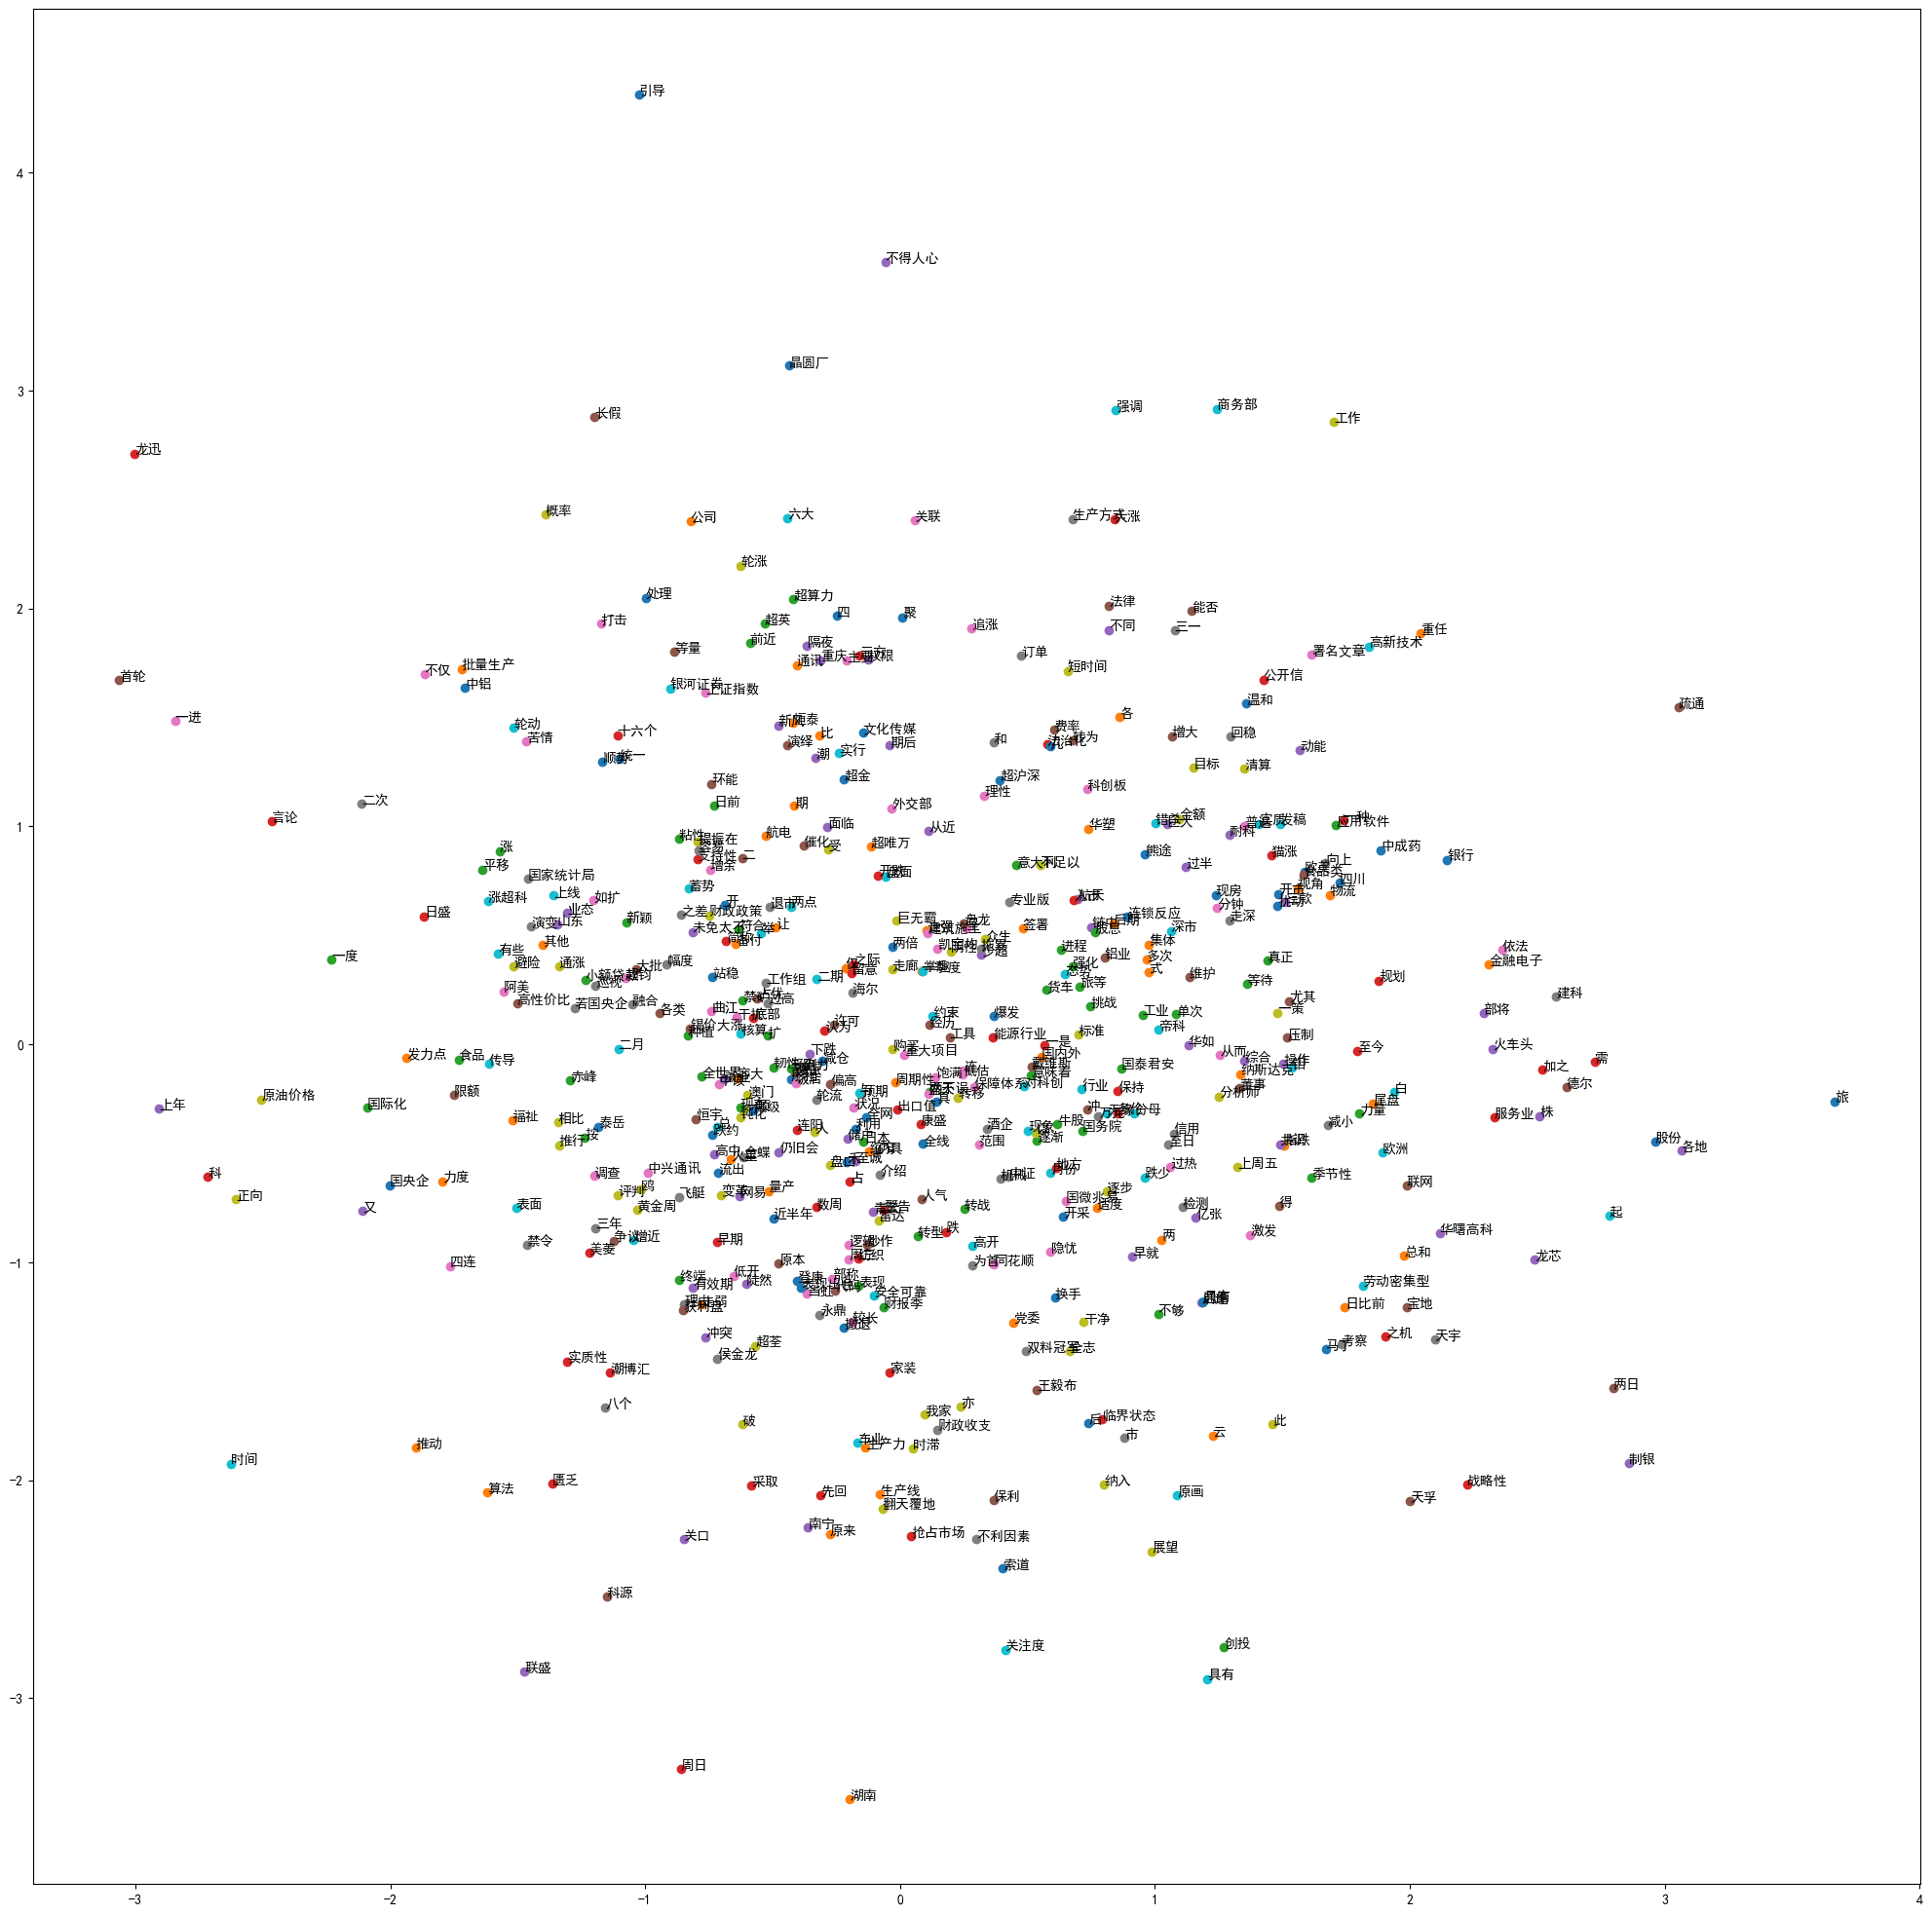

In [25]:
# 将词向量可视化
plt.figure(figsize=(25, 25))
# 只画出500个，太多显示效果很差
count = 0
for word, wordvec in word2ReduceDimensionVec.items():
    if count < 1200:
        count += 1
    elif count < 1700:
        plt.scatter(wordvec[0], wordvec[1])
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号，否则负号会显示成方块
        plt.annotate(word, (wordvec[0], wordvec[1]))
        count += 1
plt.savefig('p3-c.png')
plt.show()

In [23]:
i = 0
for word, wordvec in word2ReduceDimensionVec.items():
    if word == '涨':
        print(i)
    i+=1

1472
